### *This file allows to initialize a STG spiking neuron as well as neuromodulating them in a robust way with a controller*

# **Useful packages and functions**

In [1]:
using DifferentialEquations, Plots, Plots.PlotMeasures, LaTeXStrings, Random, Dierckx
include("STG_kinetics.jl") # Loading of STG kinetics of gating variables
include("STG_models.jl") # Loading of STG model
include("STG_utils.jl") # Loading of some utils functions
include("STG_gs_derivatives.jl") # Loading of X_inf derivatives
include("STG_DIC.jl") # Loading of the DIC and compensation algorithm
include("STG_neuromodulation.jl"); # Loading of the neuromodulation cells functions

# **Global variables**

In [2]:
# Definition of simulation time (in ms)
const Tfinal = 300000
const tspan  = (0.0, Tfinal)

# Definition of reversal potential values (in mV) and membrane capacitance
const VNa   = 50. # Sodium reversal potential
const VK    = -80. # Potassium reversal potential
const VCa   = 80. # Calcium reversal potential
const VH    = -20. # Reversal potential for the H-current (permeable to both sodium and potassium ions)
const Vleak = -50. # Reversal potential of leak channels
const C     = 1. # Membrane capacitance

# Definition of voltage range for the DICs
const Vmin = -60 
const Vmax = 0
const V    = range(Vmin, stop=Vmax, step=0.01)

# Definition of the number of cells in the random set
const ncells = 200

# Modifying backend GR attributes
gr(guidefontsize=18, legendfontsize=12, margin=5Plots.mm, grid=false)
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1)
myGray = RGBA(150/255, 150/255, 150/255, 1)
myLightBlue = RGBA(127/255, 154/255, 209/255, 1)
default(fmt = :png);

# **Neuromodulation gCaS and gA overall**

## **Computation of gCaS and gA**

In [3]:
# Fixing random seed
Random.seed!(544)

# Initial firing pattern
guth = 4.
Vth = -50.
(g_all_init, ICs_th_init) = degeneracy_fixDICs_neuromod(ncells, 5., guth, Vth);
# create a spiking set with max variability in gCaS and gA

In [4]:
# Definition of parameters
α = 5e-3 # Rate of transfer between intracellular and membrane
β = 5e-3 # Rate of degradation of intracellular proteins
Kp = 3e-4 # Proprtional gain
Ki = 5e-6 # Integral gain
Kt = β / Ki # Anti-windup gain
gsth_sim(t) = 5. - 13. * pulse(t, 35000., 50000.) # Reference
guth_sim(t) = 4.
u_maxCaS = 1e7 # Maximum value of actuator
u_maxA = 1e7

# Definition of homeostatic parameters
tau_g = 100 # Conductance time constant
Ca_tgt(t) = 125. # Calcium target

# Input current definition
Iapp = 0.

tt = 0. : 0.2 : 50000.

tt2 = 0. : 0.2 : Tfinal
end_i = findall(tt2.==60000)[1]

tt_s = 0. : 0.1 : 80.;

## **Simulation to prove that homeostasis crashes, neuron 1**

In [5]:
Random.seed!(22)
# Extracting the maximal ion channel conductances
rng_i1 = mod(rand(Int, 1)[1], ncells) + 1
(gNa1, gCaT1, gCaS1, gA1, gKCa1, gKd1, gH1, gleak1) = g_all_init[rng_i1, :];

In [6]:
# Definition of homeostatic parameters
tau_Na1 = 600 # Integral action time constants
tau_CaT1 = tau_Na1 * gNa1 / gCaT1
tau_KCa1 = tau_Na1 * gNa1 / gKCa1
tau_Kd1 = tau_Na1 * gNa1 / gKd1
tau_H1 = tau_Na1 * gNa1 / gH1
tau_leak1 = tau_Na1 * gNa1 / gleak1
tau_CaS1 = tau_Na1 * gNa1 / gCaS1
tau_A1 = tau_Na1 * gNa1 / gA1;

In [7]:
## Simulation of the model in current-clamp mode
# Parameter vector for simulations
p1 = (Iapp, gNa1, gCaT1, gKCa1, gKd1, gH1, gleak1, C, α, β, Kp, Ki, Kt, 
      gsth_sim, guth_sim, ICs_th_init[:, 1][rng_i1], u_maxCaS, u_maxA)

# Initial conditions
V0  = -70.
Ca0 = 0.5
x01  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), 
        hCaS_inf(V0), mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), 
        Ca0, gCaS1, gCaS1, (β * gCaS1) / Ki, gA1, gA1, (β * gA1) / Ki]

# Simulation
prob1 = ODEProblem(simple_PI_STG_ODE, x01, (0, 50000.), p1) # Describing the problem
sol1 = solve(prob1) # Solving the problem

# Retrieving variables
x1            = sol1(tt)
VV_plot1      = x1[1, :]
Ca_plot1      = x1[13, :]
gCaS_plot1    = x1[15, :]
gA_plot1      = x1[18, :];

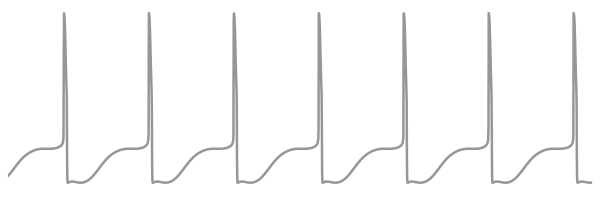

In [11]:
p = plot(tt/1e3, VV_plot1, xlims=(4.52, 4.98), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myGray, margins=0px)
display(p)
# savefig(p, "./figures/STG_spiking1.pdf")

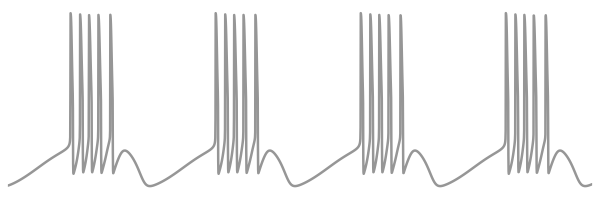

In [9]:
p = plot(tt/1e3, VV_plot1, xlims=(45.52, 46.12), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myGray, margins=0px)
display(p)
# savefig(p, "./figures/STG_bursting1.pdf")

In [10]:
## Simulation of the model in current-clamp mode
# Parameter vector for simulations
gNa_crash_init1 = gNa1
gCaT_crash_init1 = gCaT1
gCaS_crash_init1 = gCaS_plot1[end]
gA_crash_init1 = gA_plot1[end]
gKCa_crash_init1 = gKCa1
gKd_crash_init1 = gKd1
gH_crash_init1 = gH1
gleak_crash_init1 = gleak1

p1_2 = (Iapp, tau_Na1, tau_CaT1, tau_CaS1, tau_A1, tau_KCa1, tau_Kd1, tau_H1, tau_leak1, tau_g, Ca_tgt, C)

# Initial conditions
V0  = -70.
Ca0 = 0.5
x01_2  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), hCaS_inf(V0), 
          mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0, 
          gNa_crash_init1, gCaT_crash_init1, gCaS_crash_init1, gA_crash_init1, 
          gKCa_crash_init1, gKd_crash_init1, gH_crash_init1, gleak_crash_init1,
          gNa_crash_init1, gCaT_crash_init1, gCaS_crash_init1, gA_crash_init1, 
          gKCa_crash_init1, gKd_crash_init1, gH_crash_init1, gleak_crash_init1]

# Simulation
prob1_2 = ODEProblem(STG_homeo_leak_ODE, x01_2, tspan, p1_2) # Describing the problem
sol1_2 = solve(prob1_2) # Solving the problem

# Retrieving variables
x1_2          = sol1_2(tt2)
VV_plot1_2    = x1_2[1, :]
Ca_plot1_2    = x1_2[13, :]
gNa_plot1_2   = x1_2[14, :]
gCaT_plot1_2  = x1_2[15, :]
gCaS_plot1_2  = x1_2[16, :]
gA_plot1_2    = x1_2[17, :]
gKCa_plot1_2  = x1_2[18, :]
gKd_plot1_2   = x1_2[19, :]
gH_plot1_2    = x1_2[20, :];

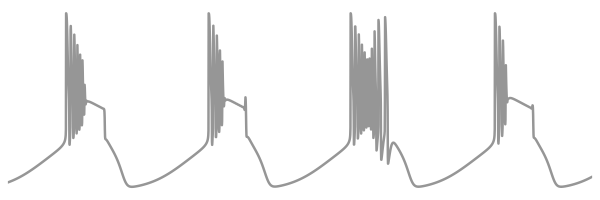

In [11]:
p = plot(tt2/1e3, VV_plot1_2, xlims=(45.52, 46.12), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myGray, margins=0px)
display(p)
# savefig(p, "./figures/STG_bursting_crash1.pdf")

In [12]:
gCaS_nmodonly1 = gCaS_plot1[Int64(30000/0.2 + 1):500:end]
gA_nmodonly1 = gA_plot1[Int64(30000/0.2 + 1):500:end]

gCaS_crash1 = [gCaS_nmodonly1; gCaS_plot1_2[2:500:end_i]]
gA_crash1 = [gA_nmodonly1; gA_plot1_2[2:500:end_i]]

gNa_nmodonly1 = gNa_crash_init1 * ones(length(gCaS_nmodonly1))
gCaT_nmodonly1 = gCaT_crash_init1 * ones(length(gCaS_nmodonly1))
gKCa_nmodonly1 = gKCa_crash_init1 * ones(length(gCaS_nmodonly1))
gKd_nmodonly1 = gKd_crash_init1 * ones(length(gCaS_nmodonly1))
gH_nmodonly1 = gH_crash_init1 * ones(length(gCaS_nmodonly1))

gNa_crash1 = [gNa_nmodonly1; gNa_plot1_2[2:500:end_i]]
gCaT_crash1 = [gCaT_nmodonly1; gCaT_plot1_2[2:500:end_i]]
gKCa_crash1 = [gKCa_nmodonly1; gKCa_plot1_2[2:500:end_i]]
gKd_crash1 = [gKd_nmodonly1; gKd_plot1_2[2:500:end_i]]
gH_crash1 = [gH_nmodonly1; gH_plot1_2[2:500:end_i]];

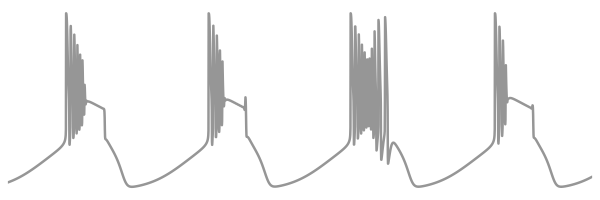

In [13]:
p = plot(tt2/1e3, VV_plot1_2, xlims=(45.52, 46.12), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myGray, margins=0px)
display(p)
# savefig(p, "./figures/STG_bursting_crash1.pdf")

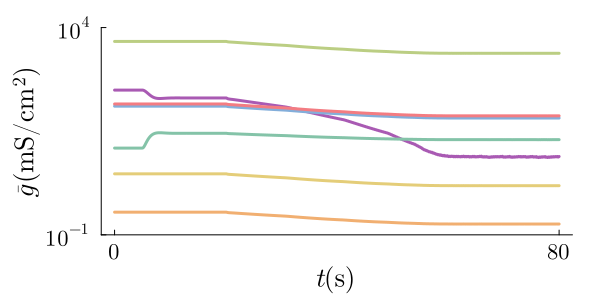

In [14]:
pp1 = plot(ylims=(1e-1, 1e4), yticks=([1e-1, 1e4], [L"10^{-1}", L"10^{4}"]), guidefontsize=18,
           xticks=([0, 80], [L"0", L"80"]), tickfontsize=15, size=(600, 300))
xlabel!(L"t\mathrm{(s)}")
ylabel!(L"\bar{g}\,\mathrm{(mS/cm^2)}")
plot!(tt_s, gA_crash1, color=myPurple, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt_s, gCaS_crash1, color=myGreen, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt_s, gNa_crash1, color=myApple, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gCaT_crash1, color=myYellow, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gKCa_crash1, color=myBlue, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gKd_crash1, color=myPink, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gH_crash1, color=myOrange, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
display(pp1)
# savefig(pp1, "./figures/crash_g_all_1.pdf")

## **Simulation to prove that homeostasis crashes, neuron 2**

In [15]:
Random.seed!(2025)
# Extracting the maximal ion channel conductances
rng_i2 = mod(rand(Int, 1)[1], ncells) + 1
(gNa2, gCaT2, gCaS2, gA2, gKCa2, gKd2, gH2, gleak2) = g_all_init[rng_i2, :];

In [16]:
# Definition of homeostatic parameters
tau_Na2 = 600 # Integral action time constants
tau_CaT2 = tau_Na2 * gNa2 / gCaT2
tau_KCa2 = tau_Na2 * gNa2 / gKCa2
tau_Kd2 = tau_Na2 * gNa2 / gKd2
tau_H2 = tau_Na2 * gNa2 / gH2
tau_leak2 = tau_Na2 * gNa2 / gleak2
tau_CaS2 = tau_Na2 * gNa2 / gCaS2
tau_A2 = tau_Na2 * gNa2 / gA2;

In [17]:
## Simulation of the model in current-clamp mode
# Parameter vector for simulations
p2 = (Iapp, gNa2, gCaT2, gKCa2, gKd2, gH2, gleak2, C, α, β, Kp, Ki, Kt, 
      gsth_sim, guth_sim, ICs_th_init[:, 1][rng_i2], u_maxCaS, u_maxA)

# Initial conditions
V0  = -70.
Ca0 = 0.5
x02  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), 
        hCaS_inf(V0), mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), 
        Ca0, gCaS2, gCaS2, (β * gCaS2) / Ki, gA2, gA2, (β * gA2) / Ki]

# Simulation
prob2 = ODEProblem(simple_PI_STG_ODE, x02, (0, 50000.), p2) # Describing the problem
sol2 = solve(prob2) # Solving the problem

# Retrieving variables
x2            = sol2(tt)
VV_plot2      = x2[1, :]
Ca_plot2      = x2[13, :]
gCaS_plot2    = x2[15, :]
gA_plot2      = x2[18, :];

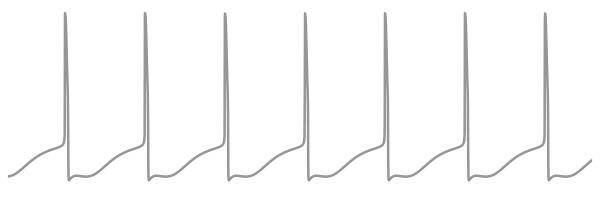

In [18]:
p = plot(tt/1e3, VV_plot2, xlims=(4.51, 4.95), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myGray, margins=0px)
display(p)
# savefig(p, "./figures/STG_spiking2.pdf")

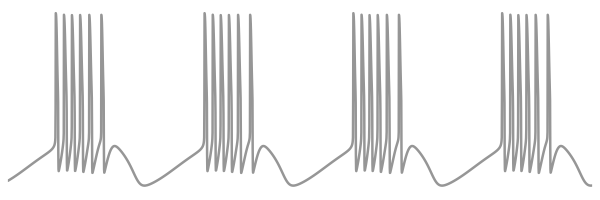

In [19]:
p = plot(tt/1e3, VV_plot2, xlims=(45.59, 46.19), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myGray, margins=0px)
display(p)
# savefig(p, "./figures/STG_bursting2.pdf")

In [20]:
## Simulation of the model in current-clamp mode
# Parameter vector for simulations
gNa_crash_init2 = gNa2
gCaT_crash_init2 = gCaT2
gCaS_crash_init2 = gCaS_plot2[end]
gA_crash_init2 = gA_plot2[end]
gKCa_crash_init2 = gKCa2
gKd_crash_init2 = gKd2
gH_crash_init2 = gH2
gleak_crash_init2 = gleak2
p2_2 = (Iapp, tau_Na2, tau_CaT2, tau_CaS2, tau_A2, tau_KCa2, tau_Kd2, tau_H2, tau_leak2, tau_g, Ca_tgt, C)

# Initial conditions
V0  = -70.
Ca0 = 0.5
x02_2  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), hCaS_inf(V0), 
          mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0, 
          gNa_crash_init2, gCaT_crash_init2, gCaS_crash_init2, gA_crash_init2, 
          gKCa_crash_init2, gKd_crash_init2, gH_crash_init2, gleak_crash_init2,
          gNa_crash_init2, gCaT_crash_init2, gCaS_crash_init2, gA_crash_init2, 
          gKCa_crash_init2, gKd_crash_init2, gH_crash_init2, gleak_crash_init2]

# Simulation
prob2_2 = ODEProblem(STG_homeo_leak_ODE, x02_2, tspan, p2_2) # Describing the problem
sol2_2 = solve(prob2_2) # Solving the problem

# Retrieving variables
x2_2          = sol2_2(tt2)
VV_plot2_2    = x2_2[1, :]
Ca_plot2_2    = x2_2[13, :]
gNa_plot2_2   = x2_2[14, :]
gCaT_plot2_2  = x2_2[15, :]
gCaS_plot2_2  = x2_2[16, :]
gA_plot2_2    = x2_2[17, :]
gKCa_plot2_2  = x2_2[18, :]
gKd_plot2_2   = x2_2[19, :]
gH_plot2_2    = x2_2[20, :];

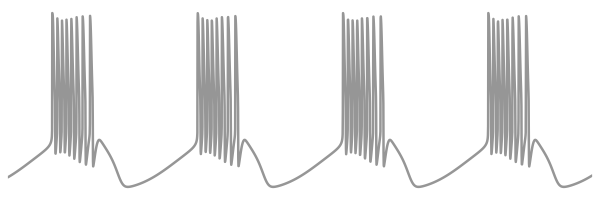

In [21]:
p = plot(tt2/1e3, VV_plot2_2, xlims=(245.55, 246.15), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myGray, margins=0px)
display(p)
# savefig(p, "./figures/STG_bursting_crash2.pdf")

In [22]:
gCaS_nmodonly2 = gCaS_plot2[Int64(30000/0.2 + 1):500:end]
gA_nmodonly2 = gA_plot2[Int64(30000/0.2 + 1):500:end]

gCaS_crash2 = [gCaS_nmodonly2; gCaS_plot2_2[2:500:end_i]]
gA_crash2 = [gA_nmodonly2; gA_plot2_2[2:500:end_i]]

gNa_nmodonly2 = gNa_crash_init2 * ones(length(gCaS_nmodonly2))
gCaT_nmodonly2 = gCaT_crash_init2 * ones(length(gCaS_nmodonly2))
gKCa_nmodonly2 = gKCa_crash_init2 * ones(length(gCaS_nmodonly2))
gKd_nmodonly2 = gKd_crash_init2 * ones(length(gCaS_nmodonly2))
gH_nmodonly2 = gH_crash_init2 * ones(length(gCaS_nmodonly2))

gNa_crash2 = [gNa_nmodonly2; gNa_plot2_2[2:500:end_i]]
gCaT_crash2 = [gCaT_nmodonly2; gCaT_plot2_2[2:500:end_i]]
gKCa_crash2 = [gKCa_nmodonly2; gKCa_plot2_2[2:500:end_i]]
gKd_crash2 = [gKd_nmodonly2; gKd_plot2_2[2:500:end_i]]
gH_crash2 = [gH_nmodonly2; gH_plot2_2[2:500:end_i]];

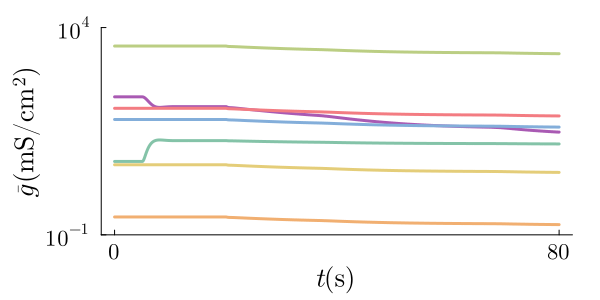

In [23]:
pp2 = plot(ylims=(1e-1, 1e4), yticks=([1e-1, 1e4], [L"10^{-1}", L"10^{4}"]), guidefontsize=18,
           xticks=([0, 80], [L"0", L"80"]), tickfontsize=15, size=(600, 300))
xlabel!(L"t\mathrm{(s)}")
ylabel!(L"\bar{g}\,\mathrm{(mS/cm^2)}")
plot!(tt_s, gA_crash2, color=myPurple, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt_s, gCaS_crash2, color=myGreen, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt_s, gNa_crash2, color=myApple, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gCaT_crash2, color=myYellow, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gKCa_crash2, color=myBlue, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gKd_crash2, color=myPink, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gH_crash2, color=myOrange, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
display(pp2)
# savefig(pp2, "./figures/crash_g_all_2.pdf")

## **Simulation to prove that homeostasis crashes, neuron 3**

In [24]:
Random.seed!(2024)
# Extracting the maximal ion channel conductances
rng_i3 = mod(rand(Int, 1)[1], ncells) + 1
(gNa3, gCaT3, gCaS3, gA3, gKCa3, gKd3, gH3, gleak3) = g_all_init[rng_i3, :];

In [25]:
# Definition of homeostatic parameters
tau_Na3 = 600 # Integral action time constants
tau_CaT3 = tau_Na3 * gNa3 / gCaT3
tau_KCa3 = tau_Na3 * gNa3 / gKCa3
tau_Kd3 = tau_Na3 * gNa3 / gKd3
tau_H3 = tau_Na3 * gNa3 / gH3
tau_leak3 = tau_Na3 * gNa3 / gleak3
tau_CaS3 = tau_Na3 * gNa3 / gCaS3
tau_A3 = tau_Na3 * gNa3 / gA3;

In [26]:
## Simulation of the model in current-clamp mode
# Parameter vector for simulations
p3 = (Iapp, gNa3, gCaT3, gKCa3, gKd3, gH3, gleak3, C, α, β, Kp, Ki, Kt, 
      gsth_sim, guth_sim, ICs_th_init[:, 1][rng_i3], u_maxCaS, u_maxA)

# Initial conditions
V0  = -70.
Ca0 = 0.5
x03  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), 
        hCaS_inf(V0), mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), 
        Ca0, gCaS3, gCaS3, (β * gCaS3) / Ki, gA3, gA3, (β * gA3) / Ki]

# Simulation
prob3 = ODEProblem(simple_PI_STG_ODE, x03, (0, 50000.), p3) # Describing the problem
sol3 = solve(prob3) # Solving the problem

# Retrieving variables
x3            = sol3(tt)
VV_plot3      = x3[1, :]
Ca_plot3      = x3[13, :]
gCaS_plot3    = x3[15, :]
gA_plot3      = x3[18, :];

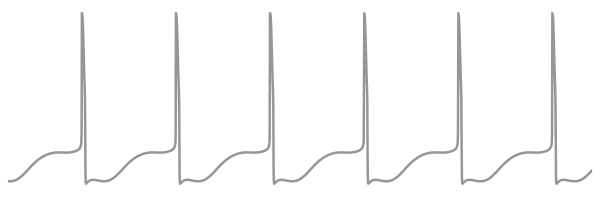

In [27]:
p = plot(tt/1e3, VV_plot3, xlims=(4.48, 4.9), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myGray, margins=0px)
display(p)
# savefig(p, "./figures/STG_spiking3.pdf")

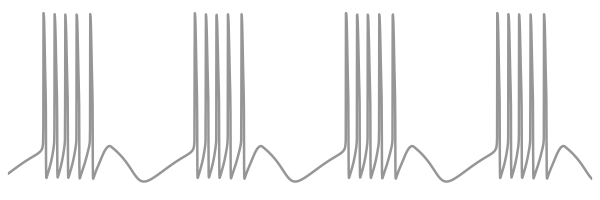

In [28]:
p = plot(tt/1e3, VV_plot3, xlims=(45.57, 46.17), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myGray, margins=0px)
display(p)
# savefig(p, "./figures/STG_bursting3.pdf")

In [29]:
## Simulation of the model in current-clamp mode
# Parameter vector for simulations
gNa_crash_init3 = gNa3
gCaT_crash_init3 = gCaT3
gCaS_crash_init3 = gCaS_plot3[end]
gA_crash_init3 = gA_plot3[end]
gKCa_crash_init3 = gKCa3
gKd_crash_init3 = gKd3
gH_crash_init3 = gH3
gleak_crash_init3 = gleak3
#Ca_tgt4(t) = 125.
p3_2 = (Iapp, tau_Na3, tau_CaT3, tau_CaS3, tau_A3, tau_KCa3, tau_Kd3, tau_H3, tau_leak3, tau_g, Ca_tgt, C)

# Initial conditions
V0  = -70.
Ca0 = 0.5
x03_2  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), hCaS_inf(V0), 
          mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0, 
          gNa_crash_init3, gCaT_crash_init3, gCaS_crash_init3, gA_crash_init3, 
          gKCa_crash_init3, gKd_crash_init3, gH_crash_init3, gleak_crash_init3,
          gNa_crash_init3, gCaT_crash_init3, gCaS_crash_init3, gA_crash_init3, 
          gKCa_crash_init3, gKd_crash_init3, gH_crash_init3, gleak_crash_init3]

# Simulation
prob3_2 = ODEProblem(STG_homeo_leak_ODE, x03_2, tspan, p3_2) # Describing the problem
sol3_2 = solve(prob3_2) # Solving the problem

# Retrieving variables
x3_2          = sol3_2(tt2)
VV_plot3_2    = x3_2[1, :]
Ca_plot3_2    = x3_2[13, :]
gNa_plot3_2   = x3_2[14, :]
gCaT_plot3_2  = x3_2[15, :]
gCaS_plot3_2  = x3_2[16, :]
gA_plot3_2    = x3_2[17, :]
gKCa_plot3_2  = x3_2[18, :]
gKd_plot3_2   = x3_2[19, :]
gH_plot3_2    = x3_2[20, :];

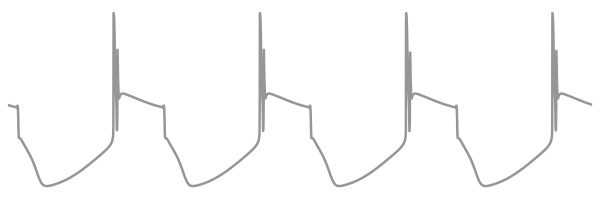

In [30]:
p = plot(tt2/1e3, VV_plot3_2, xlims=(245.57, 246.22), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myGray, margins=0px)
display(p)
# savefig(p, "./figures/STG_bursting_crash3.pdf")

In [31]:
gCaS_nmodonly3 = gCaS_plot3[Int64(30000/0.2 + 1):500:end]
gA_nmodonly3 = gA_plot3[Int64(30000/0.2 + 1):500:end]

gCaS_crash3 = [gCaS_nmodonly3; gCaS_plot3_2[2:500:end_i]]
gA_crash3 = [gA_nmodonly3; gA_plot3_2[2:500:end_i]]
gA_crash_nonneg3 = max.(gA_crash3, 1e-5)


gNa_nmodonly3 = gNa_crash_init3 * ones(length(gCaS_nmodonly3))
gCaT_nmodonly3 = gCaT_crash_init3 * ones(length(gCaS_nmodonly3))
gKCa_nmodonly3 = gKCa_crash_init3 * ones(length(gCaS_nmodonly3))
gKd_nmodonly3 = gKd_crash_init3 * ones(length(gCaS_nmodonly3))
gH_nmodonly3 = gH_crash_init3 * ones(length(gCaS_nmodonly3))

gNa_crash3 = [gNa_nmodonly3; gNa_plot3_2[2:500:end_i]]
gCaT_crash3 = [gCaT_nmodonly3; gCaT_plot3_2[2:500:end_i]]
gKCa_crash3 = [gKCa_nmodonly3; gKCa_plot3_2[2:500:end_i]]
gKd_crash3 = [gKd_nmodonly3; gKd_plot3_2[2:500:end_i]]
gH_crash3 = [gH_nmodonly3; gH_plot3_2[2:500:end_i]];

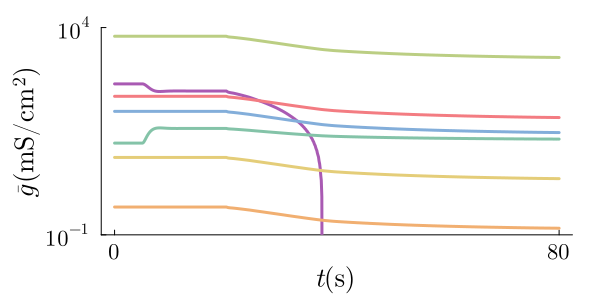

In [32]:
pp3 = plot(ylims=(1e-1, 1e4), yticks=([1e-1, 1e4], [L"10^{-1}", L"10^{4}"]), guidefontsize=18,
           xticks=([0, 80], [L"0", L"80"]), tickfontsize=15, size=(600, 300))
xlabel!(L"t\mathrm{(s)}")
ylabel!(L"\bar{g}\,\mathrm{(mS/cm^2)}")
plot!(tt_s, gA_crash_nonneg3, color=myPurple, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt_s, gCaS_crash3, color=myGreen, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt_s, gNa_crash3, color=myApple, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gCaT_crash3, color=myYellow, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gKCa_crash3, color=myBlue, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gKd_crash3, color=myPink, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gH_crash3, color=myOrange, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
display(pp3)
# savefig(pp3, "./figures/crash_g_all_3.pdf")

## **Activation and deactivation of different controllers**

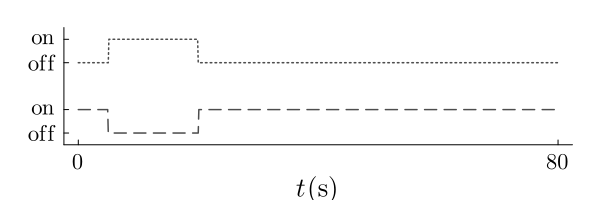

In [33]:
ppp = plot(ylims=(0, 5), guidefontsize=18, xticks=([0, 80], [L"0", L"80"]), tickfontsize=15, size=(600, 200))
tt_signals = 0 : 0.1 : 80
homeo_crash(t) = 1.5*(t>20||t<5) + 0.5 * (t<=20&&t>=5)
nmod_crash(t) = 4.5*(t<20&&t>5) + 3.5*(t>=20||t<=5)
homeo_nocrash(t) = 1.5*(t>20||t<5) + 0.5 * (t<=20&&t>=5)
nmod_nocrash(t) = 3.5*(t>5) + 2.5*(t<=5)
xlabel!(L"t\,\mathrm{(s)}")
plot!(tt_signals, nmod_crash.(tt_signals), color=:gray30, linewidth=1.5, linestyle=:dot, legend=false,
    label=L"\mathrm{Neuromodulation}\,\, \mathrm{controller}")
plot!(tt_signals, homeo_crash.(tt_signals), color=:gray30, linewidth=1.5, linestyle=:dash,
    label=L"\mathrm{Homeostatic}\,\, \mathrm{controller}", ytickfontsize=15)
yticks!([0.5, 1.5, 3.5, 4.5], [L"\mathrm{off}", L"\mathrm{on}", L"\mathrm{off}", L"\mathrm{on}"])
display(ppp)
# savefig(ppp, "./figures/offon_crash.pdf")